In [59]:
import Project_library as pl
import jax
import jax.numpy as jnp

import cvxpy as cp

In [60]:
min_observation = jnp.deg2rad(30)
# Calculate the visible area, given the minimum observational angle

# Only works when at equator
def visible_angle(min_observation, satellite_position : jnp.ndarray) -> tuple[float, float, float, float, float, float]:
    """Calculate the visible angle area of a satellite given its position.

    Args:
        min_observation (float): The minimum observational angle in radians.
        satellite_position (jnp.ndarray): The position of the satellite in Cartesian coordinates.

    Returns:
        tuple: A tuple containing the visible area and the radius of the visible area.
    """
    # Calculate the distance from the satellite to the center of the Earth
    distance = jnp.linalg.norm(satellite_position)
    # Calculate the radius of the Earth
    earth_radius = 6371  # in km

    #
    bing = jnp.sin(min_observation+jnp.pi/2)

    print(bing)

    # Calculate the angle of the satellite
    alpha = jnp.arcsin(earth_radius*bing/distance)
    # Calculate the angle from the center of the earth
    lat_width = jnp.pi/2 - alpha - min_observation

    # Calculate the spherical value of the satellite
    radius, longitude, latitude = pl.cartesian_to_spherical(*satellite_position)
    
    # Define the ranges of the visible area
    lat_range = (latitude.item() - lat_width, latitude.item() + lat_width)
    lon_range = (longitude.item() - lat_width, longitude.item() + lat_width)

    print(longitude, latitude, lat_range, lon_range)


    return lat_range, lon_range, radius, alpha, distance, lat_width

In [61]:
radius_earth = 6371 # in km
satellite_altitude = 600 # in km

# Set satellite above the equator
satellite_position = jnp.array([radius_earth + satellite_altitude, 0, 0]) # in km


# Calculate the visible area
lat_range, lon_range, radius, alpha, distance, lat_width = visible_angle(min_observation, satellite_position)

# Generate the grid of points to evaluate the visible area, given a grid size of 50 km
grid_size = 50 # in km

angle_of_cell_size = grid_size/radius_earth
print(angle_of_cell_size)

# Calculate the number of cells in the grid
num_cells_lat = int((lat_range[1] - lat_range[0]) / angle_of_cell_size)
num_cells_lon = int((lon_range[1] - lon_range[0]) / angle_of_cell_size)

# Generate the grid of points
mesh_grid = jnp.stack(pl.generate_latitude_longitude_points(num_cells_lat, num_cells_lon,lat_range, lon_range), axis=-1)

# Print the mesh grid

0.8660254
0.0 0.0 (Array(-0.13396132, dtype=float32), Array(0.13396132, dtype=float32)) (Array(-0.13396132, dtype=float32), Array(0.13396132, dtype=float32))
0.007848061528802385


In [62]:
# Create a random distribution of demand of the grid points, as the points represent an agregate user.
r = 0.3
demand = jax.random.uniform(jax.random.PRNGKey(0), shape=(num_cells_lat, num_cells_lon), minval=r*200e3, maxval=r*750e3)

users = []

# Create a user with the demand on the set point in the grid
for i in range(num_cells_lat):
    mini_user = []
    for j in range(num_cells_lon):
        if demand[i,j] > 0:
            # Create a user with the demand on the set point in the grid
            mini_user.append(pl.User(mesh_grid[i,j][0]
                                    ,mesh_grid[i,j][1],
                                     i*num_cells_lat+j
                                     ,demand[i,j],
                                      position=pl.spherical_to_cartesian(radius_earth, mesh_grid[i,j][0], mesh_grid[i,j][1])))
            
    users.append(mini_user)


In [63]:
print(users[0][0].position)

(Array(6263.9004, dtype=float32), Array(-819.0611, dtype=float32), Array(-826.03357, dtype=float32))


In [64]:
# Calculate the distance between users and the satellite
d = []
for i in range(num_cells_lat):
    dm  = []
    for j in range(num_cells_lon):
        if demand[i,j] > 0:
            # Calculate the distance between the user and the satellite
            dm.append(jnp.linalg.norm(jnp.asarray(users[i][j].position )- satellite_position))
    d.append(dm)

d = jnp.array(d).flatten()

           

In [65]:
import importlib.util
spec = importlib.util.find_spec("Project_library")
print("Found at:", spec.origin if spec else "Not found")

Found at: c:\Users\David\non_sync_documents\P10masters\P10masters\.venv\lib\site-packages\Project_library\__init__.py


In [66]:
# Satellite def
Satellite_power_per_beam = 75 # in W
Satellite_beams = 100 # Number of beams
Satellite_bandwidth = 30e6 # in Hz
Sky_temperature = 290 # in K
Satellite_gain = 30 # in dB
Satellite_central_frequency = 2 # in GHz

snr = jax.vmap(pl.calculate_snr, in_axes=(None,None,None,0,None))(Satellite_power_per_beam, Satellite_gain, Satellite_bandwidth, d, 0)

# Calculate the rate
Rates = jax.vmap(pl.calculate_capacity, in_axes=(0,None))(snr, Satellite_bandwidth)

Rates

Array([8105391., 8469170., 8841373., ..., 8841373., 8469170., 8105391.],      dtype=float32)

In [67]:
# Flatten the users
#users = [user for sublist in users for user in sublist]
#i = 1
#users[0]

In [68]:
for i in range(len(d)):
    print(users[i//num_cells_lon][i%num_cells_lon].demand)

#print(users)

216365.06
221465.69
114828.09
137330.3
154031.64
87308.0
111182.11
173764.3
183216.48
88217.4
222583.38
64171.633
165606.9
152843.98
208370.28
214198.69
197633.12
179726.67
144125.77
64562.605
65195.65
218073.1
145605.17
190715.33
151119.92
160873.23
207373.95
184573.5
94920.9
97842.7
70217.3
162124.7
141136.45
149941.27
128092.305
147138.33
192536.64
93924.45
141538.05
132633.0
90363.98
96944.24
164027.34
190484.31
145309.4
106487.6
115983.01
64308.77
209478.9
187818.45
153098.38
140207.56
75122.84
167756.42
173075.92
190226.62
103416.914
200339.25
97812.63
115046.11
127806.836
109771.88
67843.64
183795.31
157339.88
79633.62
87117.836
205915.94
93015.96
182976.38
201445.14
162923.55
170415.53
205096.48
194967.39
206728.58
108245.53
192674.06
141975.66
172538.25
82061.74
224320.75
194170.28
198629.84
159117.9
150704.28
204840.8
155123.53
130003.65
114648.43
80766.305
155423.12
204990.58
91551.78
193824.88
120288.26
132913.77
89779.87
210920.83
95915.98
165991.9
197857.9
142027.86
15625

In [69]:
# Define the variables
time_slot = 1 # in seconds
time_window = 20 # in seconds

print(len(d))

x = cp.Variable((time_window, len(d)), boolean=True) # Binary variable for the user assignment

constraints = []

# Constraints for the user assignment
# (C1) Each user can be assigned to only one satellite beam


# (C2) The demand of the users must be satisfied
for i in range(len(d)):
    constraints.append(cp.sum(x[:,i] * Rates[i]) >= users[i//num_cells_lon][i%num_cells_lon].demand)

# (C3) The number of beams at any time slot must not exceed the number of beams available
for t in range(time_window):
    constraints.append(cp.sum(x[t,:]) <= Satellite_beams)

# x can only be binary
# (C4) The value can only be binary
constraints.append(x >= 0)
constraints.append(x <= 1)
# (C3) The value can only be binary
#constraints.append(x >= 0)
#constraints.append(x <= 1)



objective = cp.Minimize(0) # Dummy objective function, as we are only interested in the feasibility


problem = cp.Problem(objective, constraints)
problem.solve()

if x.value is not None:
    schedule = jnp.round(x.value).astype(int)
    print("Schedule:")
    print(schedule)
else:
    print("No feasible solution found.")

1156
Schedule:
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


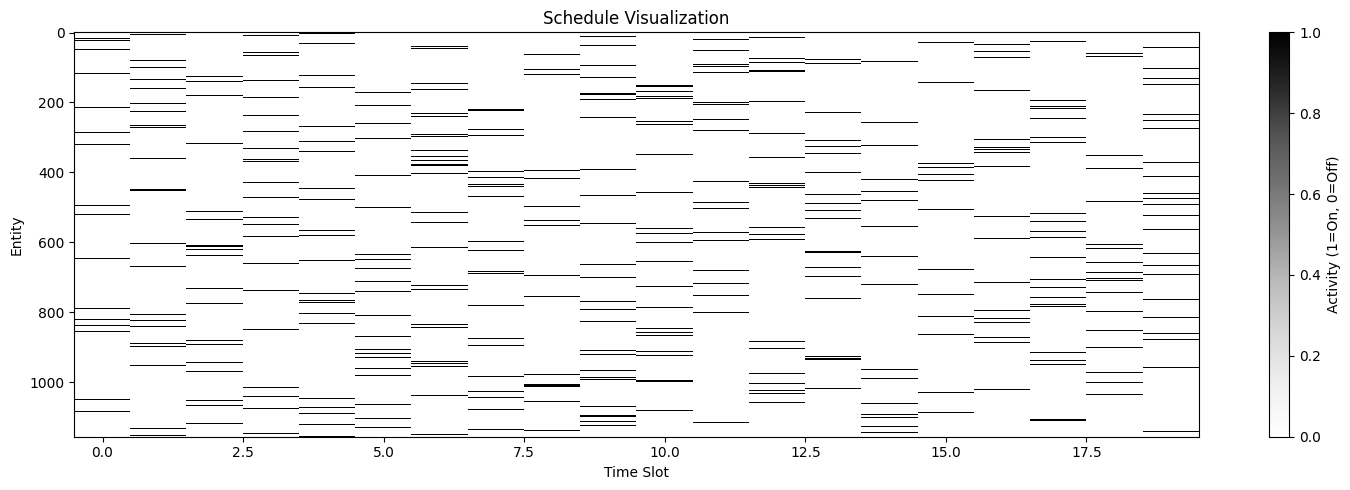

In [70]:
import matplotlib.pyplot as plt

jnp.round(x.value).astype(int).shape



plt.figure(figsize=(15, 5))
plt.imshow(schedule.T, aspect='auto', cmap='Greys', interpolation='None')
plt.colorbar(label='Activity (1=On, 0=Off)')
plt.xlabel('Time Slot')
plt.ylabel('Entity')
plt.title('Schedule Visualization')
plt.tight_layout()
plt.show()

In [71]:
# Calculate the sum of x over the time window for each enitity
sum_x = jnp.sum(jnp.round(x.value).astype(int), axis=1)
print("Sum of x over the time window for each entity:")
print(sum_x)
print(sum_x.shape)

# Check if every value is 0 or 1
for i in range(schedule.shape[0]):
    for k in range(schedule.shape[1]):
        if schedule[i][k] > 1:
            print("Error: More than one value is 1")
        elif schedule[i][k] < 0:
            print("Error: Less than 0 value is 1")
        


Sum of x over the time window for each entity:
[58 54 52 62 53 60 74 70 62 60 53 56 52 54 60 46 54 64 54 58]
(20,)


In [72]:
# Setup the optimization problem

# Define the variables
time_slot = 0.1 # in seconds
time_window = 10 # in seconds

print(time_window/time_slot)

number_of_time_slots = int(time_window/time_slot)

x = cp.Variable((number_of_time_slots, len(d)), boolean=True) # Binary variable for the user assignment

constraints = []

constraints.append(x >= 0)
constraints.append(x <= 1)

objective = cp.Minimize(cp.max(cp.min(1/number_of_time_slots*cp.sum(x, axis=1))))

# Constaint

problem = cp.Problem(objective, constraints)
problem.solve()

if x.value is not None:
    schedule = jnp.round(x.value).astype(int)
    print("Schedule:")
    print(schedule)
else:
    print("No feasible solution found.")

100.0


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
max(min(Promote(0.01, (100,)) @ Sum(var553291, 1, False), None, False), None, False)